# Part 1

### 0. make database

In [ ]:
import duckdb
import pandas as pd
import glob

# Get all CSV files in the current directory after downloading them
csv_files = glob.glob('./*.csv')

# Establish a connection to a DuckDB in-memory database (or specify a file to store it persistently)
con = duckdb.connect('my_database.duckdb')

# Load each CSV into the DuckDB database
for csv_file in csv_files:
    # Use pandas to read the CSV file
    df = pd.read_csv(csv_file)
    
    # Get the table name from the CSV filename (remove the .csv extension)
    table_name = csv_file.split('/')[-1].split('.')[0]
    
    # Write the DataFrame to the DuckDB database
    con.execute(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

# Optionally, check the tables that have been created
tables = con.execute("SHOW TABLES").fetchall()
print("Tables in the database:", tables)

# Close the connection
#con.close()


Tables in the database: [('ADMISSIONS',), ('DRGCODES',), ('D_ICD_PROCEDURES',), ('ICUSTAYS',), ('PATIENTS',), ('PRESCRIPTIONS',), ('PROCEDURES_ICD',)]


### 1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.


In [125]:
top_10_drugs_df = con.sql("""
    SELECT 
        p.drug, 
        COUNT(DISTINCT p.subject_id) AS total_users
    FROM 
        PRESCRIPTIONS p
    GROUP BY 
        p.drug
    ORDER BY 
        total_users DESC
    LIMIT 10
""").df()

top_10_drugs_df

,drug,total_users
0,Sodium Chloride 0.9% Flush,72
1,Acetaminophen,69
2,Heparin,69
3,D5W,68
4,Insulin,67
5,Potassium Chloride,66
6,Iso-Osmotic Dextrose,60
7,Magnesium Sulfate,59
8,Senna,56
9,NS,56


In [137]:
drug_type_users_by_ethnicity_df = con.sql("""
WITH ranked_drug_types AS (
    SELECT 
        a.ethnicity, 
        p.drug, 
        COUNT(DISTINCT p.subject_id) AS total_users,
        ROW_NUMBER() OVER (
            PARTITION BY a.ethnicity 
            ORDER BY COUNT(DISTINCT p.subject_id) DESC
        ) AS rn
    FROM 
        ADMISSIONS a
    JOIN 
        PRESCRIPTIONS p ON a.subject_id = p.subject_id
    GROUP BY 
        a.ethnicity, 
        p.drug
)
SELECT 
    ethnicity, 
    drug, 
    total_users
FROM 
    ranked_drug_types
WHERE 
    rn <= 1
ORDER BY 
    ethnicity, total_users DESC
""").df()

drug_type_users_by_ethnicity_df


,ethnicity,drug,total_users
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Ranitidine,1
1,ASIAN,NS,2
2,BLACK/AFRICAN AMERICAN,Insulin,6
3,HISPANIC OR LATINO,MetRONIDAZOLE (FLagyl),2
4,HISPANIC/LATINO - PUERTO RICAN,Acetaminophen (Liquid),1
5,OTHER,Morphine Sulfate,2
6,UNABLE TO OBTAIN,Sucralfate,1
7,UNKNOWN/NOT SPECIFIED,Pantoprazole Sodium,5
8,WHITE,Sodium Chloride 0.9% Flush,57


In [120]:
con.sql('SELECT * FROM PRESCRIPTIONS')

┌─────────┬────────────┬─────────┬────────────┬─────────────────────┬─────────────────────┬───────────┬─────────────────────────────┬─────────────────────────────┬─────────────────────────────┬───────────────────┬─────────┬───────────────┬───────────────────────────┬─────────────┬──────────────┬───────────────┬────────────────┬─────────┐
│ row_id  │ subject_id │ hadm_id │ icustay_id │      startdate      │       enddate       │ drug_type │            drug             │        drug_name_poe        │      drug_name_generic      │ formulary_drug_cd │   gsn   │      ndc      │       prod_strength       │ dose_val_rx │ dose_unit_rx │ form_val_disp │ form_unit_disp │  route  │
│  int64  │   int64    │  int64  │   double   │       varchar       │       varchar       │  varchar  │           varchar           │           varchar           │           varchar           │      varchar      │ double  │    double     │          varchar          │   varchar   │   varchar    │    varchar    │    varc

In [270]:
drug_type_used_by_ethnicity_df = con.sql("""
WITH ranked_drug_types AS (
    SELECT 
        a.ethnicity, 
        p.drug, 
        COUNT(*) AS total_used,
        ROW_NUMBER() OVER (
            PARTITION BY a.ethnicity 
            ORDER BY COUNT(*) DESC
        ) AS rn
    FROM 
        ADMISSIONS a
    JOIN 
        PRESCRIPTIONS p ON a.subject_id = p.subject_id
    GROUP BY 
        a.ethnicity, 
        p.drug
)
SELECT 
    ethnicity, 
    drug, 
    total_used
FROM 
    ranked_drug_types
WHERE 
    rn <= 1
ORDER BY 
    ethnicity, total_used DESC
""").df()

drug_type_used_by_ethnicity_df


,ethnicity,drug,total_used
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
1,ASIAN,D5W,27
2,BLACK/AFRICAN AMERICAN,Insulin,60
3,HISPANIC OR LATINO,5% Dextrose,28
4,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,1290
5,OTHER,NS,11
6,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
7,UNKNOWN/NOT SPECIFIED,D5W,41
8,WHITE,Potassium Chloride,508


In [266]:
drug_type_used_by_ethnicity_df

,ethnicity,drug,total_usage
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Vial,4
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Multivitamin IV,2
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Acyclovir,4
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Ondansetron,4
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,traZODONE,4
...,...,...,...
1255,WHITE,0.9% Sodium Chloride,338
1256,WHITE,NS,366
1257,WHITE,Diazepam,8
1258,WHITE,Lansoprazole Oral Suspension,8


### 2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.



In [205]:
df_age_procedures = con.sql("""
WITH PATIENT_AGE AS (
    SELECT 
        ADMISSIONS.hadm_id,
        DATE_DIFF('day', CAST(dob AS DATE), CAST(admittime AS DATE)) / 365.25 AS age_at_admission
    FROM 
        PATIENTS
    JOIN 
        ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
),
PROCS AS (
    SELECT 
        PROCEDURES_ICD.hadm_id, 
        D_ICD_PROCEDURES.short_title
    FROM 
        PROCEDURES_ICD
    JOIN 
        D_ICD_PROCEDURES ON D_ICD_PROCEDURES.icd9_code = PROCEDURES_ICD.icd9_code
),
COMBINED AS (
    SELECT 
        PATIENT_AGE.age_at_admission,
        PROCS.short_title,
        CASE
            WHEN age_at_admission <= 19 THEN '0–19'
            WHEN age_at_admission BETWEEN 20 AND 49 THEN '20–49'
            WHEN age_at_admission BETWEEN 50 AND 79 THEN '50–79'
            ELSE '80+'
        END AS age_group
    FROM 
        PATIENT_AGE
    JOIN 
        PROCS ON PATIENT_AGE.hadm_id = PROCS.hadm_id
),
RANKED AS (
    SELECT 
        age_group,
        short_title,
        COUNT(*) AS procedure_count,
        ROW_NUMBER() OVER (
            PARTITION BY age_group 
            ORDER BY COUNT(*) DESC
        ) AS rn
    FROM 
        COMBINED
    GROUP BY 
        age_group, short_title
)
SELECT 
    age_group, 
    short_title AS procedure, 
    procedure_count
FROM 
    RANKED
WHERE 
    rn <= 3
ORDER BY 
    age_group, procedure_count DESC
""").df()


In [206]:
df_age_procedures

,age_group,procedure,procedure_count
0,0–19,Venous cath NEC,2
1,0–19,Temporary tracheostomy,1
2,0–19,Closed bronchial biopsy,1
3,20–49,Venous cath NEC,8
4,20–49,Entral infus nutrit sub,7
5,20–49,Insert endotracheal tube,6
6,50–79,Venous cath NEC,25
7,50–79,Entral infus nutrit sub,22
8,50–79,Packed cell transfusion,13
9,80+,Venous cath NEC,21


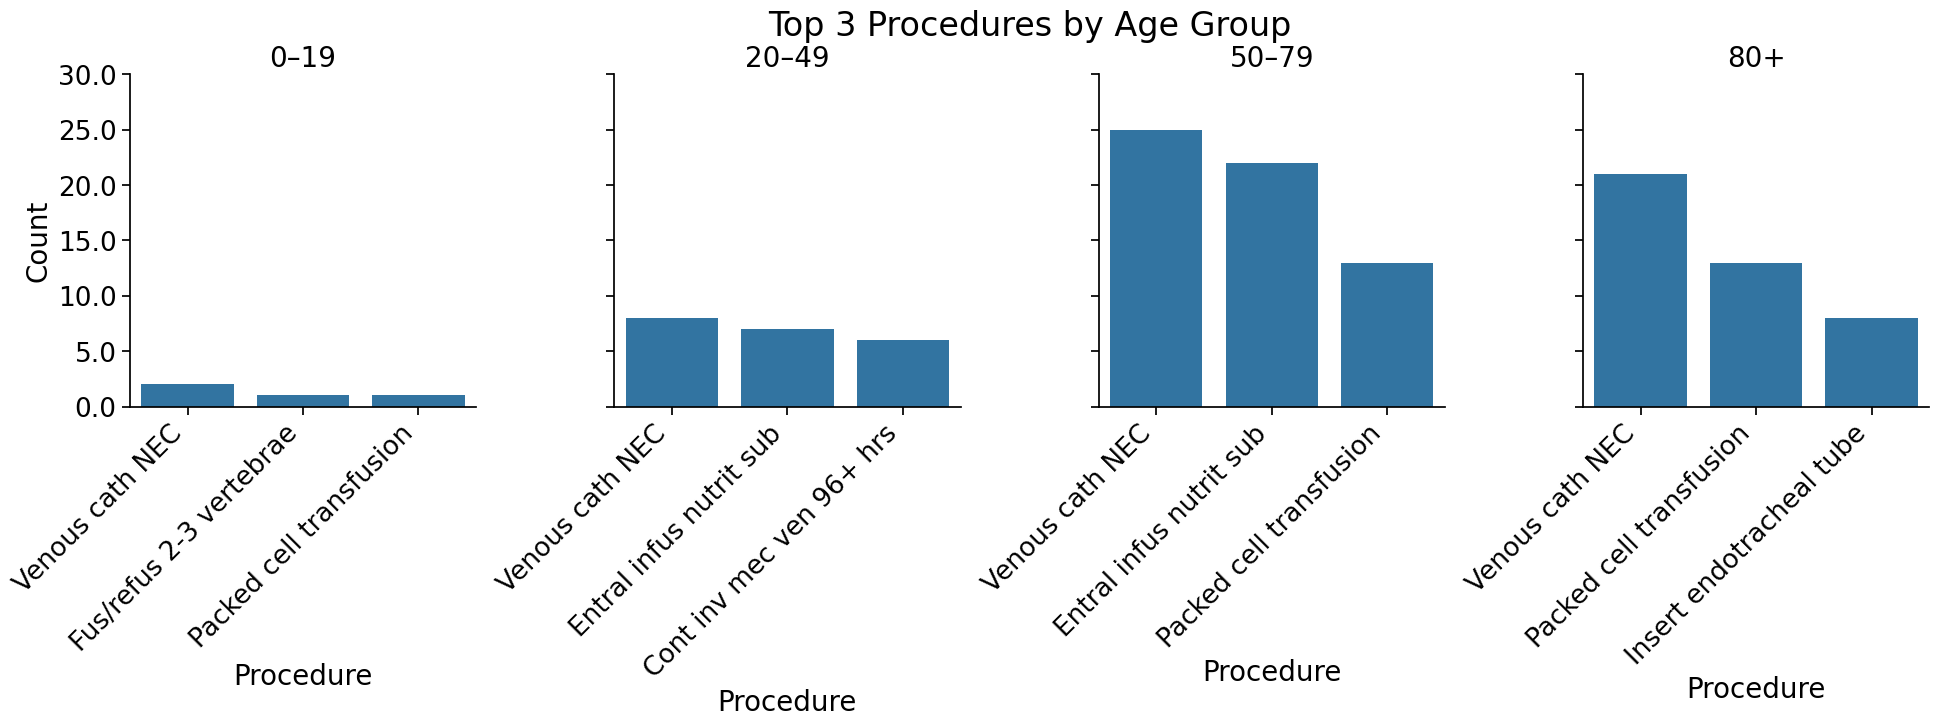

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set global font scale
sns.set_context("notebook", font_scale=1.5)  # Try 2.0 or higher if needed

# Set up FacetGrid
g = sns.FacetGrid(
    df_age_procedures,
    col="age_group",
    col_order=["0–19", "20–49", "50–79", "80+"],
    height=5,
    sharex=False
)
g.map_dataframe(sns.barplot, x="procedure", y="procedure_count")

# Rotate x labels and format
for ax in g.axes.flat:
    # Rotate x labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=19)

    # Ensure y-ticks are set before setting y-tick labels
    ax.set_yticks(ax.get_yticks())  # Explicitly set the y-ticks
    ax.set_yticklabels(ax.get_yticks(), fontsize=19)

# Set titles and labels with larger font
g.set_titles(col_template="{col_name}", size=20)
g.set_axis_labels("Procedure", "Count", fontsize=20)

# Adjust layout and set main title
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Top 3 Procedures by Age Group", fontsize=24)
plt.show()


### 3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?
 

In [62]:
con.sql("""
SELECT AVG(LOS) 
FROM ICUSTAYS
""")

┌───────────────────┐
│     avg(LOS)      │
│      double       │
├───────────────────┤
│ 4.452456617647062 │
└───────────────────┘

In [102]:
LOS_ethnicity = con.sql("""
    SELECT 
        a.ETHNICITY,
        AVG(i.LOS) AS avg_los
    FROM ICUSTAYS i
    JOIN ADMISSIONS a ON i.subject_id = a.subject_id AND i.hadm_id = a.hadm_id
    JOIN PATIENTS p ON i.subject_id = p.subject_id
    GROUP BY a.ETHNICITY
    ORDER BY avg_los ASC
""").df()


In [272]:
round(LOS_ethnicity, 2)

,ethnicity,avg_los
0,OTHER,0.93
1,HISPANIC/LATINO - PUERTO RICAN,3.24
2,ASIAN,3.89
3,WHITE,4.13
4,UNKNOWN/NOT SPECIFIED,4.93
5,HISPANIC OR LATINO,7.46
6,BLACK/AFRICAN AMERICAN,7.68
7,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,11.34
8,UNABLE TO OBTAIN,13.36


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_40334/2533929230.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_40334/2533929230.py:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



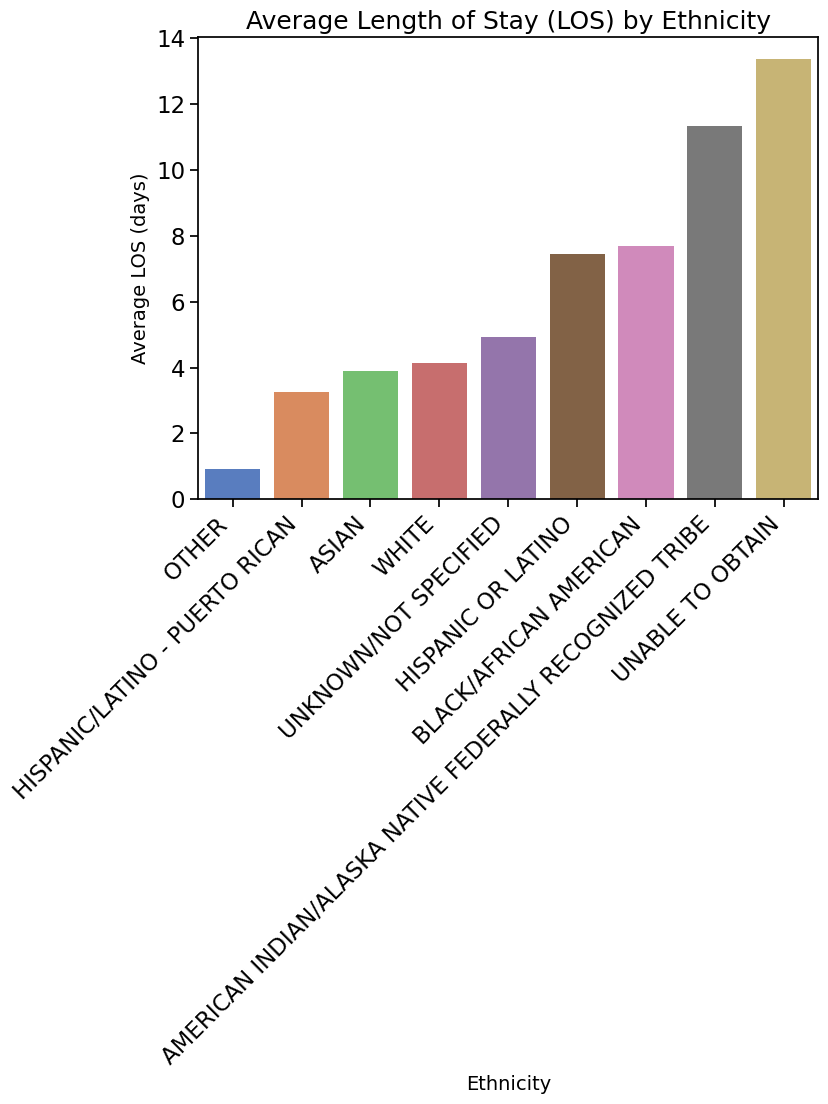

In [105]:
# Set global font scale for the plot
sns.set_context("notebook", font_scale=1.5)

# Create a barplot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=LOS_ethnicity, x='ethnicity', y='avg_los', palette='muted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title("Average Length of Stay (LOS) by Ethnicity", fontsize=18)
plt.xlabel("Ethnicity", fontsize=14)
plt.ylabel("Average LOS (days)", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

In [107]:
LOS_gender = con.sql("""
    SELECT 
        p.GENDER,
        AVG(i.LOS) AS avg_los
    FROM ICUSTAYS i
    JOIN ADMISSIONS a ON i.subject_id = a.subject_id AND i.hadm_id = a.hadm_id
    JOIN PATIENTS p ON i.subject_id = p.subject_id
    GROUP BY p.GENDER
    ORDER BY avg_los DESC
""").df()


In [109]:
LOS_gender

,gender,avg_los
0,F,5.540071
1,M,3.513830


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_40334/1172766767.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




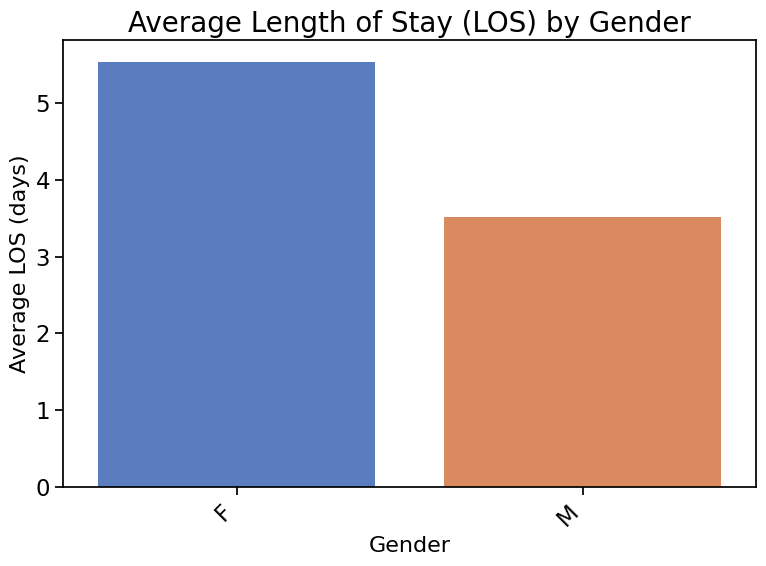

In [108]:
# Set global font scale for the plot
sns.set_context("notebook", font_scale=1.5)

# Create a barplot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=LOS_gender, x='gender', y='avg_los', palette='muted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title("Average Length of Stay (LOS) by Gender", fontsize=20)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Average LOS (days)", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


## part 2

### Set up keyspace

In [110]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('../Lab4/sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_40334/2156252505.py:7: DeprecationWarning:

ssl.PROTOCOL_TLSv1_2 is deprecated



In [111]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

In [112]:
#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

In [113]:
# establishing connection to Keyspace
session = cluster.connect()

In [130]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('kyan_shlipak_hw2')  # Replace with your keyspace

### Cassandra Query 1

In [177]:
# This gets raw, unaggregated data that is only joined
joined_df = con.sql("""
    SELECT 
        a.subject_id, 
        a.ethnicity, 
        p.drug
    FROM 
        ADMISSIONS a
    JOIN 
        PRESCRIPTIONS p 
        ON a.subject_id = p.subject_id
""").df()

In [178]:
joined_df

,subject_id,ethnicity,drug
0,42458,WHITE,Pneumococcal Vac Polyvalent
1,42458,WHITE,Bisacodyl
2,42458,WHITE,Bisacodyl
3,42458,WHITE,Senna
4,42458,WHITE,Docusate Sodium (Liquid)
...,...,...,...
29736,10117,UNKNOWN/NOT SPECIFIED,Gabapentin
29737,10117,UNKNOWN/NOT SPECIFIED,Acetaminophen
29738,10117,UNKNOWN/NOT SPECIFIED,Zolpidem Tartrate
29739,10117,UNKNOWN/NOT SPECIFIED,Docusate Sodium


In [184]:
# Create the table
session.execute("""
    CREATE TABLE IF NOT EXISTS subject_drugs_by_ethnicity (
        ethnicity TEXT,
        subject_id TEXT,
        drug TEXT,
        PRIMARY KEY ((ethnicity), subject_id, drug)
    );
""")

In [186]:
from cassandra.query import BatchStatement, BatchType

prepared = session.prepare("""
    INSERT INTO subject_drugs_by_ethnicity (ethnicity, subject_id, drug)
    VALUES (?, ?, ?)
""")

batch = BatchStatement(batch_type=BatchType.UNLOGGED)
batch_size = 30
total_rows = len(joined_df)

for i, row in joined_df.iterrows():
    batch.add(prepared, (row.ethnicity, str(row.subject_id), row.drug))
    
    if (i + 1) % batch_size == 0:
        session.execute(batch)
        batch.clear()
        percentage_done = ((i + 1) / total_rows) * 100
        print(f"Inserted {i + 1} of {total_rows} rows ({percentage_done:.2f}% done)...")

# Final batch
if batch:
    session.execute(batch)
    print(f"Inserted final {total_rows} rows.")


Inserted 30 of 29741 rows (0.10% done)...
Inserted 60 of 29741 rows (0.20% done)...
Inserted 90 of 29741 rows (0.30% done)...
Inserted 120 of 29741 rows (0.40% done)...
Inserted 150 of 29741 rows (0.50% done)...
Inserted 180 of 29741 rows (0.61% done)...
Inserted 210 of 29741 rows (0.71% done)...
Inserted 240 of 29741 rows (0.81% done)...
Inserted 270 of 29741 rows (0.91% done)...
Inserted 300 of 29741 rows (1.01% done)...
Inserted 330 of 29741 rows (1.11% done)...
Inserted 360 of 29741 rows (1.21% done)...
Inserted 390 of 29741 rows (1.31% done)...
Inserted 420 of 29741 rows (1.41% done)...
Inserted 450 of 29741 rows (1.51% done)...
Inserted 480 of 29741 rows (1.61% done)...
Inserted 510 of 29741 rows (1.71% done)...
Inserted 540 of 29741 rows (1.82% done)...
Inserted 570 of 29741 rows (1.92% done)...
Inserted 600 of 29741 rows (2.02% done)...
Inserted 630 of 29741 rows (2.12% done)...
Inserted 660 of 29741 rows (2.22% done)...
Inserted 690 of 29741 rows (2.32% done)...
Inserted 720 o

In [188]:
# Query to retrieve drug usage data (subject_id, drug)
query = "SELECT subject_id, drug FROM subject_drugs_by_ethnicity"
subject_drug = session.execute(query)

# Convert Cassandra result set to DataFrame
subject_drug_df = pd.DataFrame(subject_drug)

drug_usage = subject_drug_df.groupby('drug')['subject_id'].nunique().reset_index()

# Sort by the number of distinct users, in descending order
drug_usage_sorted = drug_usage.sort_values(by='subject_id', ascending=False)

# Get the top 10 drugs
top_10_drugs = drug_usage_sorted.head(10)
top_10_drugs

,drug,subject_id
517,Sodium Chloride 0.9% Flush,72
12,Acetaminophen,69
254,Heparin,69
147,D5W,68
284,Insulin,67
470,Potassium Chloride,66
288,Iso-Osmotic Dextrose,60
333,Magnesium Sulfate,59
386,NS,56
506,Senna,56


In [ ]:
query = "SELECT subject_id, drug, ethnicity FROM subject_drugs_by_ethnicity"
ethnicity_drug = session.execute(query)
ethnicity_drug_df = pd.DataFrame(ethnicity_drug)

# Count distinct users (subject_id) for each drug within each ethnicity
drug_usage_by_ethnicity = ethnicity_drug_df.groupby(['ethnicity', 'drug'])['subject_id'].nunique().reset_index()

# Sort by the number of distinct users, in descending order
drug_usage_sorted_by_ethnicity = drug_usage_by_ethnicity.sort_values(by='subject_id', ascending=False)

# For each ethnicity, get the top three drugs by number of distinct users
top_drugs_by_ethnicity = drug_usage_sorted_by_ethnicity.groupby('ethnicity').head(3)

# Display the result
top_drugs_by_ethnicity

,ethnicity,drug,subject_id
1192,WHITE,Sodium Chloride 0.9% Flush,57
965,WHITE,Heparin,55
869,WHITE,D5W,53
205,BLACK/AFRICAN AMERICAN,Insulin,6
142,BLACK/AFRICAN AMERICAN,Acetaminophen,5
708,UNKNOWN/NOT SPECIFIED,Pantoprazole Sodium,5
209,BLACK/AFRICAN AMERICAN,Iso-Osmotic Dextrose,5
655,UNKNOWN/NOT SPECIFIED,D5W,5
721,UNKNOWN/NOT SPECIFIED,Senna,5
326,HISPANIC OR LATINO,Lactulose,2


### Cassandra Query 2

In [221]:
con.sql("SELECT * FROM PROCEDURES_ICD")

┌────────┬────────────┬─────────┬─────────┬───────────┐
│ row_id │ subject_id │ hadm_id │ seq_num │ icd9_code │
│ int64  │   int64    │  int64  │  int64  │   int64   │
├────────┼────────────┼─────────┼─────────┼───────────┤
│   3994 │      10114 │  167957 │       1 │      3605 │
│   3995 │      10114 │  167957 │       2 │      3722 │
│   3996 │      10114 │  167957 │       3 │      8856 │
│   3997 │      10114 │  167957 │       4 │      9920 │
│   3998 │      10114 │  167957 │       5 │      9671 │
│   3999 │      10114 │  167957 │       6 │      8843 │
│   7353 │      10130 │  156668 │       1 │      4674 │
│   7354 │      10130 │  156668 │       2 │      4623 │
│   7355 │      10130 │  156668 │       3 │      8345 │
│   7356 │      10130 │  156668 │       4 │      5491 │
│     ·  │        ·   │     ·   │       · │        ·  │
│     ·  │        ·   │     ·   │       · │        ·  │
│     ·  │        ·   │     ·   │       · │        ·  │
│ 222080 │      41976 │  153826 │       3 │     

In [224]:
df_age_procedures = con.sql("""
WITH PATIENT_AGE AS (
    SELECT 
        ADMISSIONS.hadm_id,
        DATE_DIFF('day', CAST(dob AS DATE), CAST(admittime AS DATE)) / 365.25 AS age_at_admission
    FROM 
        PATIENTS
    JOIN 
        ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
),
PROCS AS (
    SELECT 
        PROCEDURES_ICD.hadm_id, 
		PROCEDURES_ICD.row_id AS procedure_row_id, 
        D_ICD_PROCEDURES.short_title
    FROM 
        PROCEDURES_ICD
    JOIN 
        D_ICD_PROCEDURES ON D_ICD_PROCEDURES.icd9_code = PROCEDURES_ICD.icd9_code
)
SELECT 
    PATIENT_AGE.hadm_id,
    PATIENT_AGE.age_at_admission,
    PROCS.short_title AS procedure,
	PROCS.procedure_row_id,
    CASE
        WHEN age_at_admission <= 19 THEN '0–19'
        WHEN age_at_admission BETWEEN 20 AND 49 THEN '20–49'
        WHEN age_at_admission BETWEEN 50 AND 79 THEN '50–79'
        ELSE '80+'
    END AS age_group
FROM 
    PATIENT_AGE
JOIN 
    PROCS ON PATIENT_AGE.hadm_id = PROCS.hadm_id
ORDER BY 
    PATIENT_AGE.hadm_id
""").df()


In [229]:
session.execute("""
CREATE TABLE subject_procedures_by_age (
    procedure_row_id text,
    age_at_admission float,
    procedure text,
    age_group text,
    PRIMARY KEY (procedure_row_id, procedure)
);
""")

In [234]:
from cassandra.query import BatchStatement, BatchType

# Prepare the insert statement
prepared = session.prepare("""
    INSERT INTO subject_procedures_by_age (procedure_row_id, age_at_admission, procedure, age_group)
    VALUES (?, ?, ?, ?)
""")

# Set up batch and batch size
batch = BatchStatement(batch_type=BatchType.UNLOGGED)
batch_size = 30
total_rows = len(df_age_procedures)  # Assuming df contains the data for insertion

# Loop through the DataFrame to insert data in batches
for i, row in df_age_procedures.iterrows():  # Assuming df contains the query results
    batch.add(prepared, (str(row['procedure_row_id']), row['age_at_admission'], row['procedure'], row['age_group']))
    
    # Execute the batch every 30 rows
    if (i + 1) % batch_size == 0:
        session.execute(batch)
        batch.clear()
        # Print progress
        percentage_done = ((i + 1) / total_rows) * 100
        print(f"Inserted {i + 1} of {total_rows} rows ({percentage_done:.2f}% done)...")

# Execute the final batch if any remaining rows
if batch:
    session.execute(batch)
    print(f"Inserted final {total_rows} rows.")

Inserted 30 of 516 rows (5.81% done)...
Inserted 60 of 516 rows (11.63% done)...
Inserted 90 of 516 rows (17.44% done)...
Inserted 120 of 516 rows (23.26% done)...
Inserted 150 of 516 rows (29.07% done)...
Inserted 180 of 516 rows (34.88% done)...
Inserted 210 of 516 rows (40.70% done)...
Inserted 240 of 516 rows (46.51% done)...
Inserted 270 of 516 rows (52.33% done)...
Inserted 300 of 516 rows (58.14% done)...
Inserted 330 of 516 rows (63.95% done)...
Inserted 360 of 516 rows (69.77% done)...
Inserted 390 of 516 rows (75.58% done)...
Inserted 420 of 516 rows (81.40% done)...
Inserted 450 of 516 rows (87.21% done)...
Inserted 480 of 516 rows (93.02% done)...
Inserted 510 of 516 rows (98.84% done)...
Inserted final 516 rows.


In [236]:
# get from cassandra
query = "SELECT procedure_row_id, age_at_admission, procedure, age_group FROM subject_procedures_by_age"
subject_procedure_data = session.execute(query)
subject_procedure_df = pd.DataFrame(subject_procedure_data)

# Group by age_group and procedure, and get the count of procedures
procedure_counts = subject_procedure_df.groupby(['age_group', 'procedure']).size().reset_index(name='procedure_count')

# Get the top 3 procedures for each age group
top_procedures_by_age_group = procedure_counts.sort_values(by=['age_group', 'procedure_count'], ascending=[True, False])
top_procedures_by_age_group = top_procedures_by_age_group.groupby('age_group').head(3)

top_procedures_by_age_group


,age_group,procedure,procedure_count
17,0–19,Venous cath NEC,2
0,0–19,Applic ext fix dev-femur,1
1,0–19,Atlas-axis fusion,1
64,20–49,Venous cath NEC,8
31,20–49,Entral infus nutrit sub,7
27,20–49,Cont inv mec ven 96+ hrs,6
163,50–79,Venous cath NEC,25
96,50–79,Entral infus nutrit sub,22
127,50–79,Packed cell transfusion,13
235,80+,Venous cath NEC,21


### Cassandra Query 3

In [259]:
los_df_og = con.sql("""
	SELECT
		a.subject_id,
		a.hadm_id,
		a.ethnicity,
		p.gender,
		i.los,
		i.icustay_id
    FROM ICUSTAYS i
    JOIN ADMISSIONS a ON i.subject_id = a.subject_id AND i.hadm_id = a.hadm_id
    JOIN PATIENTS p ON i.subject_id = p.subject_id		
""").df()

In [260]:
los_df_og

,subject_id,hadm_id,ethnicity,gender,los,icustay_id
0,10006,142345,BLACK/AFRICAN AMERICAN,F,1.6325,206504
1,10011,105331,UNKNOWN/NOT SPECIFIED,F,13.8507,232110
2,10013,165520,UNKNOWN/NOT SPECIFIED,F,2.6499,264446
3,10017,199207,WHITE,F,2.1436,204881
4,10019,177759,WHITE,M,1.2938,228977
...,...,...,...,...,...,...
131,41976,152032,HISPANIC/LATINO - PUERTO RICAN,M,2.0829,234541
132,41976,172082,HISPANIC/LATINO - PUERTO RICAN,M,10.8625,253931
133,41976,176016,HISPANIC/LATINO - PUERTO RICAN,M,10.7764,286072
134,41976,173269,HISPANIC/LATINO - PUERTO RICAN,M,2.9406,205170


In [253]:
# Create the table
session.execute("""
    CREATE TABLE IF NOT EXISTS los_data (
        ethnicity TEXT,
        gender TEXT,
        subject_id INT,
        hadm_id INT,
        los FLOAT,
	    icustay_id INT,
        PRIMARY KEY ((ethnicity, gender), subject_id, hadm_id, icustay_id)
    );
""")

In [261]:
from cassandra.query import BatchStatement, BatchType

prepared = session.prepare("""
    INSERT INTO los_data (ethnicity, gender, subject_id, hadm_id, los, icustay_id)
    VALUES (?, ?, ?, ?, ?, ?)
""")

batch = BatchStatement(batch_type=BatchType.UNLOGGED)
batch_size = 30
total_rows = len(los_df_og)

for i, row in los_df_og.iterrows():
    batch.add(prepared, (row.ethnicity, row.gender, row.subject_id, row.hadm_id, row.los, row.icustay_id))
    
    if (i + 1) % batch_size == 0:
        session.execute(batch)
        batch.clear()
        percentage_done = ((i + 1) / total_rows) * 100
        print(f"Inserted {i + 1} of {total_rows} rows ({percentage_done:.2f}% done)...")

# Final batch
if batch:
    session.execute(batch)
    print(f"Inserted final {total_rows} rows.")


Inserted 30 of 136 rows (22.06% done)...
Inserted 60 of 136 rows (44.12% done)...
Inserted 90 of 136 rows (66.18% done)...
Inserted 120 of 136 rows (88.24% done)...
Inserted final 136 rows.


In [262]:
# Step 1: Query data from Cassandra
query = "SELECT ethnicity, gender, los, icustay_id FROM los_data"
los_data = session.execute(query)
los_df = pd.DataFrame(los_data)

# Step 2: Average LOS overall
avg_los_overall = los_df['los'].mean()

# Step 3: Average LOS by gender
avg_los_by_gender = los_df.groupby('gender')['los'].mean().reset_index(name='avg_los')

# Step 4: Average LOS by ethnicity
avg_los_by_ethnicity = los_df.groupby('ethnicity')['los'].mean().reset_index(name='avg_los')

# Optional: Print or inspect
print("Average LOS overall:", avg_los_overall)
print("\nAverage LOS by gender:\n", avg_los_by_gender)
print("\nAverage LOS by ethnicity:\n", avg_los_by_ethnicity)


Average LOS overall: 4.452456642106614

Average LOS by gender:
   gender   avg_los
0      F  5.540071
1      M  3.513830

Average LOS by ethnicity:
                                            ethnicity    avg_los
0  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...  11.337150
1                                              ASIAN   3.890050
2                             BLACK/AFRICAN AMERICAN   7.676671
3                                 HISPANIC OR LATINO   7.459633
4                     HISPANIC/LATINO - PUERTO RICAN   3.243067
5                                              OTHER   0.926067
6                                   UNABLE TO OBTAIN  13.357000
7                              UNKNOWN/NOT SPECIFIED   4.925273
8                                              WHITE   4.130488


In [ ]:
###

### Gen AI Disclosure Statement

Purpose of Use:
I used a limited amount of GAI to assist with writing SQL queries, as I am quite rusty in SQL syntax, so I used ChatGPT to aid in correcting syntax errors.
Additionally, though I try to avoid this on real projects, I was swamped this week and in some cells used ChatGPT to provide more descriptive comments on elementary python code.

Tool Used: ChatGPT by OpenAI

Prompts Used: "What is wrong with this SQL query”, "Add comments to this python script"

In [275]:
!(ls)

ADMISSIONS.csv       ICUSTAYS.csv         my_database.duckdb
DRGCODES.csv         PATIENTS.csv         readme.md
D_ICD_PROCEDURES.csv PRESCRIPTIONS.csv    requirements.txt
HW2.ipynb            PROCEDURES_ICD.csv
